# FAIRshake Evaluation Summary

In [47]:
print("Created by Brian Schilder, 07/22/2018\n")
import sys
print("Python Version Info:")
print(sys.version)



Created by Brian Schilder, 07/22/2018

Python Version Info:
3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary Questions
- Average score for each question
- Standard deviation for each answer
- Correlation between questions
- Evals per person, max evals, and distribution
- Are some people generally harsher
- Which answers tended to have comments
- FAIRest tools vs. Least FAIR tools

## FAIRshake Questions
1. DESCRIPTION : The tool has a unique name and an informative description.
2. DOWNLOAD : The tool can be freely downloaded or accessed from a webpage.
3. ONTOLOGY : The tool utilizes a community-accepted ontology.
4. TUTORIAL : Tutorials for the tool are available on the tool‚Äôs homepage.
5. SOURCE CODE : Source code is shared in a public repository and is documented.
6. VERSIONING : Previous versions of the tool are made available.
7. CONTACT: Contact information is provided for the creator(s) of the tool and information describing how to cite the tool is provided.
8. API : The tool can be accessed programmatically through an API and follows community standards for open APIs.
9. LICENSE : Licensing information is provided on the tool's homepage.


In [48]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

import pandas as pd
fair = pd.read_csv("merged_FAIRshake_evals.csv", index_col=None)
fair['q_id'] = pd.Categorical(fair['q_id'])
print(fair.shape)
print(fair.columns)

qDict = {1:'1. Description', 2:'2. Download', 3:'3. Ontology', 4:'4. Tutorial', 
         5:'5. Source Code', 6:'6. Versioning', 7:'7. Contact', 8:'8. API', 9:'9. License'}
fair["q_name"] = fair['q_id'].map(qDict)
print("+++++++++++++++")
print(str(int(len(fair)/9)) + " evaluations total.")



(3789, 32)
Index(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'resource_id', 'q_id',
       'answer', 'url_comment', 'comment', 'project_id_x', 'test_x', 'num',
       'version', 'content', 'F', 'A', 'I', 'R', 'res_type', 'test_y',
       'username', 'first_name', 'middle_initial', 'last_name', 'test_x.1',
       'affiliation', 'orcid', 'resource_name', 'url', 'resource_type',
       'description', 'project_id_y', 'test_y.1'],
      dtype='object')
+++++++++++++++
421 evaluations total.


## Average score for each question

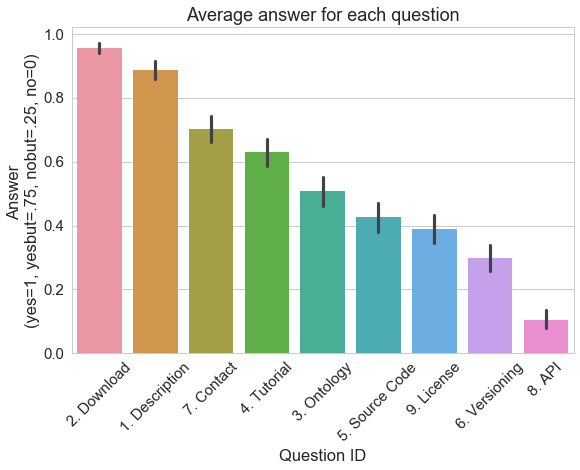

In [49]:
import seaborn as sn
sn.set(font_scale=1.5)
import matplotlib.pyplot as plt
sn.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6) 

fair.answer.unique()
fair["answer01"] = fair.answer.map(dict(yes=1, no=0, yesbut=.75, nobut=.25))
avg_per_q = fair.groupby('q_name')['q_name','answer01'].mean()
std_per_q = fair.groupby('q_name')['q_name','answer01'].std()
avg_per_q.rename(columns={'answer01':'answer01_mean'}, inplace=True)
avg_per_q = avg_per_q.sort_values(by='answer01_mean', ascending=False)

# plot
# fair = fair.merge(avg_per_q, on='q_id')
g = sn.barplot(data=fair, x='q_name', y='answer01', order=avg_per_q.index)
# ax = sn.violinplot(data=fair, x='q_id', y='answer01', order=avg_per_q.index)
g.set(ylabel='Answer \n(yes=1, yesbut=.75, nobut=.25, no=0)', xlabel='Question ID', title="Average answer for each question")
plt.xticks(rotation=45, ha='center')
plt.show()



## Frequency of each of the 4 score options for each question

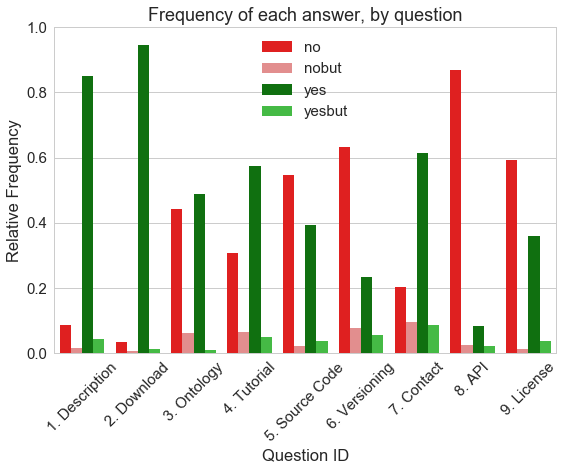

In [50]:
fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6)

scores4 = fair.groupby(['q_name','answer'])['answer'].count()
scores4.name = 'answerCount'
scores4 = scores4.reset_index()
# Calculate relative frequency 
totalCounts = scores4.groupby(by='q_name')['answerCount'].sum().reset_index()
totalCounts = totalCounts.rename(columns={'answerCount':'totalCounts_per_q_name'})
scores4 = scores4.merge(totalCounts, on='q_name')
scores4['answerCount_relFreq'] = scores4['answerCount']/scores4['totalCounts_per_q_name']
# Plot
palette ={"no":"red","nobut":"lightcoral", "yes":"green", "yesbut":"limegreen"}
g = sn.barplot(data=scores4, x='q_name', y='answerCount_relFreq', hue='answer', palette=palette)
g.set(ylabel='Relative Frequency', xlabel='Question ID', title="Frequency of each answer, by question")
g.legend()
plt.xticks(rotation=45, ha='center')
plt.ylim((0,1))
plt.show()

## Correlations between questions

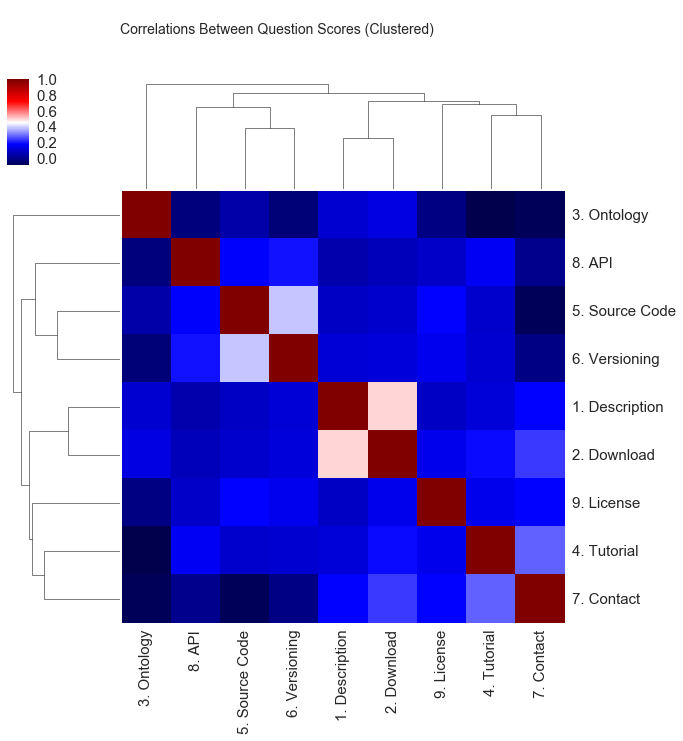

There is some correlation between q1 (Description) and q2 (Download).


In [51]:


corrDict={}
for q in fair['q_name']:
    sub = fair.loc[fair['q_name']==q]['answer01']
    corrDict[q] = sub.values
corrMatrix = pd.DataFrame(corrDict).corr()

# g = sn.heatmap(corrMatrix, annot=True, cmap='seismic')
g = sn.clustermap(data=corrMatrix, cmap='seismic').fig.suptitle('\nCorrelations Between Question Scores (Clustered)', size=14) 
# g.set(ylabel='Question ID', xlabel='Question ID', title="Correlations between all questions")
plt.show()

print("There is some correlation between q1 (Description) and q2 (Download).")


## KDE Density Plots of Evaluations Per Person

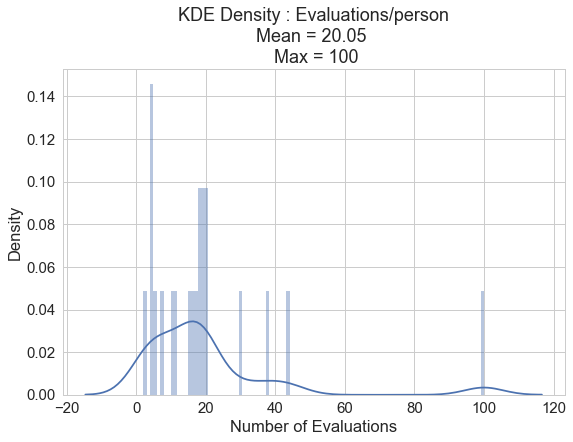

In [52]:
fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6)

evalCounts = [len(x) for x in fair.groupby('user_id')['resource_name'].unique()]
avgCounts = sum(evalCounts)/len(evalCounts)

g = sn.distplot(evalCounts, bins=100, norm_hist=False)
g.set(xlabel='Number of Evaluations', ylabel='Density', 
       title="KDE Density : Evaluations/person\n Mean = "+str(round(avgCounts,2))+"  \n Max = "+str(max(evalCounts)))
plt.show()

## Are some raters harsher than others?

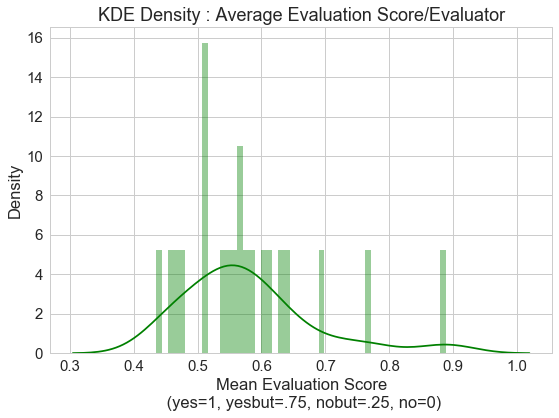

Evaluators gave a average FAIR score of 0.58 (on a 0-1 scale).


In [53]:
fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6)

avgRating = fair.groupby('user_id')['user_id','answer01'].mean() 

meanMean = avgRating['answer01'].mean()
g = sn.distplot(avgRating['answer01'], bins=50, color='green', norm_hist=False)
g.set(xlabel='Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)', ylabel='Density', 
       title="KDE Density : Average Evaluation Score/Evaluator")
plt.show()

print("Evaluators gave a average FAIR score of "+str(round(meanMean,2)) + " (on a 0-1 scale).")

## Which answers tended to have the most comments

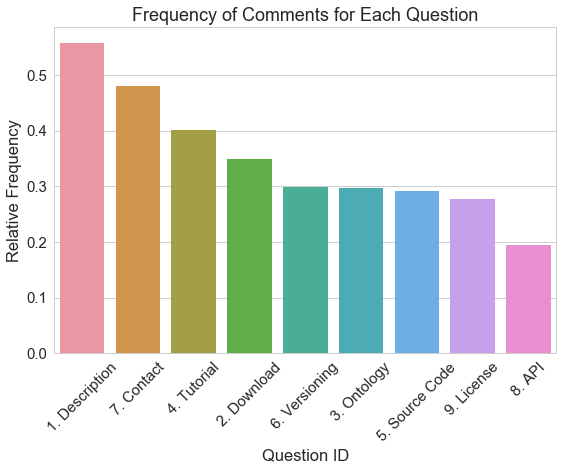

Questions 1. Description and 7. Contact most frequently had comments.


In [54]:
fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6)

commentDict={}
for q in fair['q_name'].unique():
    sub = fair.loc[fair['q_name']==q]['comment']
    notEmpty = sum(~sub.isnull())/len(sub.isnull())
    commentDict[q] = notEmpty
commentDF = pd.Series(commentDict).sort_values(ascending=False)

g = sn.barplot(x=commentDF.index, y=commentDF )
g.set(xlabel='Question ID', ylabel='Relative Frequency', 
       title="Frequency of Comments for Each Question")
plt.xticks(rotation=45, ha='center')
plt.show()

print("Questions "+commentDF.index[0]+" and "+commentDF.index[1]+ " most frequently had comments.")


## The FAIRest of the them all

In [55]:
fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6)

resourceScores = fair.groupby('resource_name')['answer01'].mean().sort_values(ascending=False).reset_index()
FAIRest = resourceScores.loc[resourceScores['answer01']==1,:]
leastFAIR  = resourceScores.loc[resourceScores['answer01']==0,:]

g = sn.barplot(data=resourceScores, x='resource_name', y='answer01')
g.set(xlabel='Resource (n = '+str(len(resourceScores))+')', ylabel='FAIR score\n(yes=1, yesbut=.75, nobut=.25, no=0)', 
       title="Mean FAIRness Scores for each resource")
g.set(xticklabels=[])
plt.show()

print("FAIRest resources (score = 1.0)")
print(FAIRest)
print("\n")
print("Least FAIR resources ( score = 0.0).")
print(leastFAIR)


## Time per Evaluation

### Histogram of FAIR scores across resources

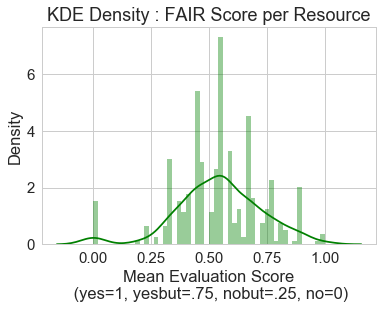

In [43]:
fig, ax = plt.subplots(figsize=(9, 6))

g = sn.distplot(resourceScores['answer01'], bins=50, color='green', norm_hist=False)
g.set(xlabel='Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)', ylabel='Density', 
       title="KDE Density : FAIR Score per Resource")
plt.show()

In [44]:
import numpy as np
import time


# Import and format Time Stamp data (from Lily Wang)
timeData=[]
with open('fairshakejam-timestamp.txt') as f:
    flines = f.readlines() 
    import ast
    for line in flines:
        if line.startswith('{'):
            timeData.append(ast.literal_eval(line.strip('\n')))
len(timeData)
timeDF = pd.DataFrame(timeData) 
timeDF.head()
len(timeDF['ip'].unique()) 
print("Earliest timeStamp = "+timeDF['timestamp'][0])
print("Latest timeStamp = "+timeDF['timestamp'].iloc[-2])


# Conditionally add new col values
conditions = [ 
    (timeDF['req'].str.split(' ').str[-1].str.startswith('/newevaluation')),
    (timeDF['req'].str.split(' ').str[-1].str.startswith('/evaluationsubmitted'))
]
choices = ['evalStart','evalEnd']
timeDF['marker'] = np.select(conditions, choices, default='')
# Parse resource ID
timeDF['resourceID'] = timeDF[timeDF['req'].str.contains('resourceid=')]['req'].str.split('resourceid=').str[-1]

print('Processing eval times')
evalLengths={}
# Loop through each person
for ip in timeDF['ip'].unique():
    # print("Processing ip - "+ip)
    sub = timeDF.loc[timeDF['ip']==ip]
    sub['resourceID'] = sub['resourceID'].fillna(method='ffill')
    for resource in sub['resourceID'].unique():
        rsub = sub.loc[sub['resourceID']==resource]
        evalStart = rsub[rsub['marker']=='evalStart']['timestamp'].values
        evalEnd = rsub[rsub['marker'] =='evalEnd']['timestamp'].values  
        # evalStart = ['20/Jul/2018:14:13:33 +0000'] 
        # evalEnd = ['20/Jul/2018:14:18:46 +0000']
        if len(evalStart)!=0 and len(evalEnd)!=0:
            # only get timestamps that start with day
            evalStart = [item for item in evalStart if item[0].isdigit()]
            evalEnd = [item for item in evalEnd if item[0].isdigit()]
            # Convert to time_struct
            timeStart = time.strptime(evalStart[0], '%d/%b/%Y:%H:%M:%S +%f')
            timeEnd = time.strptime(evalEnd[0], '%d/%b/%Y:%H:%M:%S +%f') 
            timeLength = (time.mktime(timeEnd) - time.mktime(timeStart)) / 60 # Return difference in minutes
            # Symbol translation at:  http://strftime.org/
            evalLengths[resource] = timeLength
len(evalLengths)
# Save file to csv
timeDF.to_csv('fairshakejam-timestamp_processed.csv')

Earliest timeStamp = 19/Jul/2018:14:18:54 +0000
Latest timeStamp = 23/Jul/2018:20:07:44 +0000
Processing eval times


Mean evaluation time = 28.48 minutes.
Mode evaluation time = 1.05 minutes.
Median evaluation time = 3.55 minutes.
Min evaluation time = 8.0 seconds.
Max evaluation time = 21.71 hours.


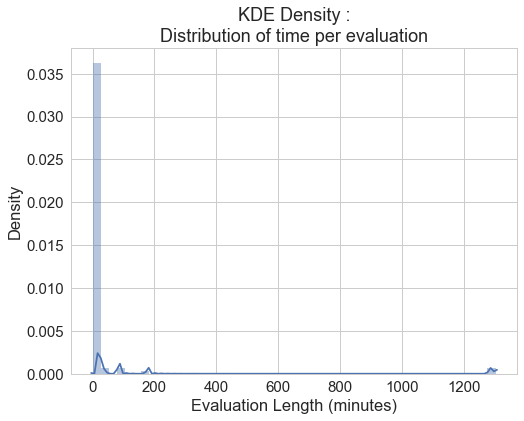

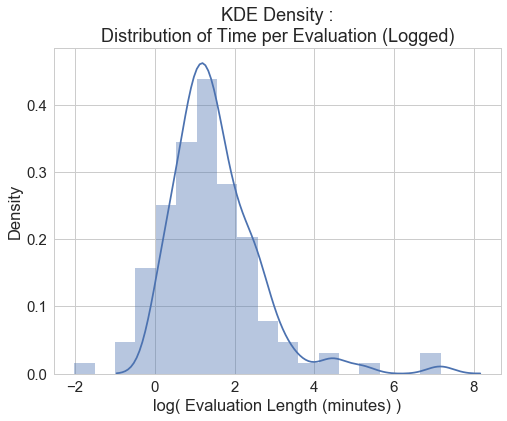

In [45]:
# Report summary stats
avgEvalTime = sum(evalLengths.values()) / len(evalLengths.values())
evalLengthsDF = pd.Series(evalLengths, name='evalLength').reset_index().rename(columns={'index':'resourceID'})
lst = list(evalLengths.values())
mode  = max(set(lst), key=lst.count)
lst_sort = sorted(lst)
median = lst_sort[int((len(lst_sort)/2)) ]

print("Mean evaluation time = "+str(round(avgEvalTime,2))+" minutes.")
print("Mode evaluation time = "+str(mode)+" minutes.")
print("Median evaluation time = "+str(median)+" minutes.") 
print("Min evaluation time = "+str(round(min(evalLengths.values())*60,2))+" seconds.")            
print("Max evaluation time = "+str(round( max(evalLengths.values())/60,2))+" hours.") 


fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6) 
g = sn.distplot(evalLengthsDF['evalLength'] )
g.set(xlabel='Evaluation Length (minutes)', ylabel='Density', 
       title="KDE Density :\nDistribution of time per evaluation")

fig2, ax2 = plt.subplots(figsize=(8, 6)) #default figsize = (8,6) 
# Log values to see distribution better
g2 = sn.distplot( np.log( evalLengthsDF['evalLength']),  kde_kws={'clip': (0.0,  max(np.log( evalLengthsDF['evalLength'])))})
g2.set(xlabel='log( Evaluation Length (minutes) )', ylabel='Density', 
       title="KDE Density :\nDistribution of Time per Evaluation (Logged)")
plt.show()
 